# Model accuracy, SHAP and feature selection using a threshold of 5 min APGAR < 5

In [1]:
threshold = 5 # Positive class is less than threshold

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Load and balance data

In [3]:
data = pd.read_csv('./data/processed_data_for_model_one_hot.csv')

In [4]:
prop_less_threshold = np.mean(data['apgar5'] < threshold)
print (f'Proportion < {threshold} = {prop_less_threshold:0.4f}')

Proportion < 5 = 0.0038


In [5]:
drop_hospitals = True

if drop_hospitals:
    selected_cols = []
    for col in list(data):
        if col[0:8] == 'hospital':
            pass
        else:
            selected_cols.append(col)
    
    data = data[selected_cols]

Balance data

In [6]:
mask = data['apgar5'] < threshold
pos_class = data[mask]
num_pos = len(mask)

mask = data['apgar5'] >= threshold
neg_class = data[mask]
num_neg = len(mask)

sample_size = max(num_neg, num_pos)

# resample
neg_class = neg_class.sample(sample_size, replace=True)
pos_class = pos_class.sample(sample_size, replace=True)

data = pd.concat([neg_class, pos_class], axis=0)
data = data.sample(frac=1.0, random_state=42, replace=False)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

Split X and y

In [7]:
y = data['apgar5'] < threshold
X = data.drop('apgar5', axis=1)

## K-fold accuracy measurement

In [8]:
# Set up splits
number_of_splits = 3
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

3

In [9]:
# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []
importances = []

# Loop through the k-fold splits
counter = 0
for train_index, test_index in skf.split(X, y):
    counter += 1
    
    # Get X and Y train/test
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Fit model
    model = XGBClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    y_class = model.predict(X_test)
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Print accuracy
    tp = np.sum((y_class == 1) & (y_test == 1))
    fp = np.sum((y_class == 1) & (y_test == 0))
    tn = np.sum((y_class == 0) & (y_test == 0))
    fn = np.sum((y_class == 0) & (y_test == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {counter}, accuracy: {accuracy:0.3f}, sensitivity: {sensitivity:0.3f}, specificity: {specificity:0.3f}')

Run 1, accuracy: 0.902, sensitivity: 0.882, specificity: 0.922
Run 2, accuracy: 0.909, sensitivity: 0.893, specificity: 0.926
Run 3, accuracy: 0.905, sensitivity: 0.887, specificity: 0.923


In [10]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(number_of_splits):
    # Get fpr, tpr and thresholds foir each k-fold from scikit-learn's ROC method
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    # Use scikit-learn's method for calulcating auc
    roc_auc = auc(fpr, tpr)
    # Store results
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    # Print auc result
    print (f'Run {i} AUC {roc_auc:0.4f}')

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.9648
Run 1 AUC 0.9683
Run 2 AUC 0.9658

Mean AUC: 0.9663
SD AUC: 0.0015


## SHAP

Fit SHAP to model, and show explainer for 25K sample.


In [11]:
model = XGBClassifier()
model.fit(X, y)


X_sample = X.sample(25000)
explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X_sample)
shap_values = explainer.shap_values(X_sample)
shap_values_extended[0]

.values =
array([ 0.25845996,  0.03470558, -0.39258975,  0.00380438, -0.0978853 ,
       -0.49829724, -0.01266411, -0.62683564, -0.06735231, -0.17311408,
        0.24004641,  0.10276828, -0.27339002,  0.01131368,  0.00529346,
        0.00591292, -0.11507678,  0.00933836, -0.01594429, -0.0173506 ,
       -0.19144279, -0.02004211, -0.19022347, -0.12160998, -0.02705532,
       -0.01708772,  0.0012909 , -0.0315912 ,  0.00946105,  0.03218869,
        0.00608904,  0.00218867, -0.22982685,  0.02074735,  0.        ,
       -0.0626865 ,  0.00339783, -0.01380586], dtype=float32)

.base_values =
0.00041297934

.data =
array([0.0, 0.0, 1.0, False, False, 18, 24, 41, True, True, True, False,
       False, False, False, False, True, False, False, True, False, False,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=object)

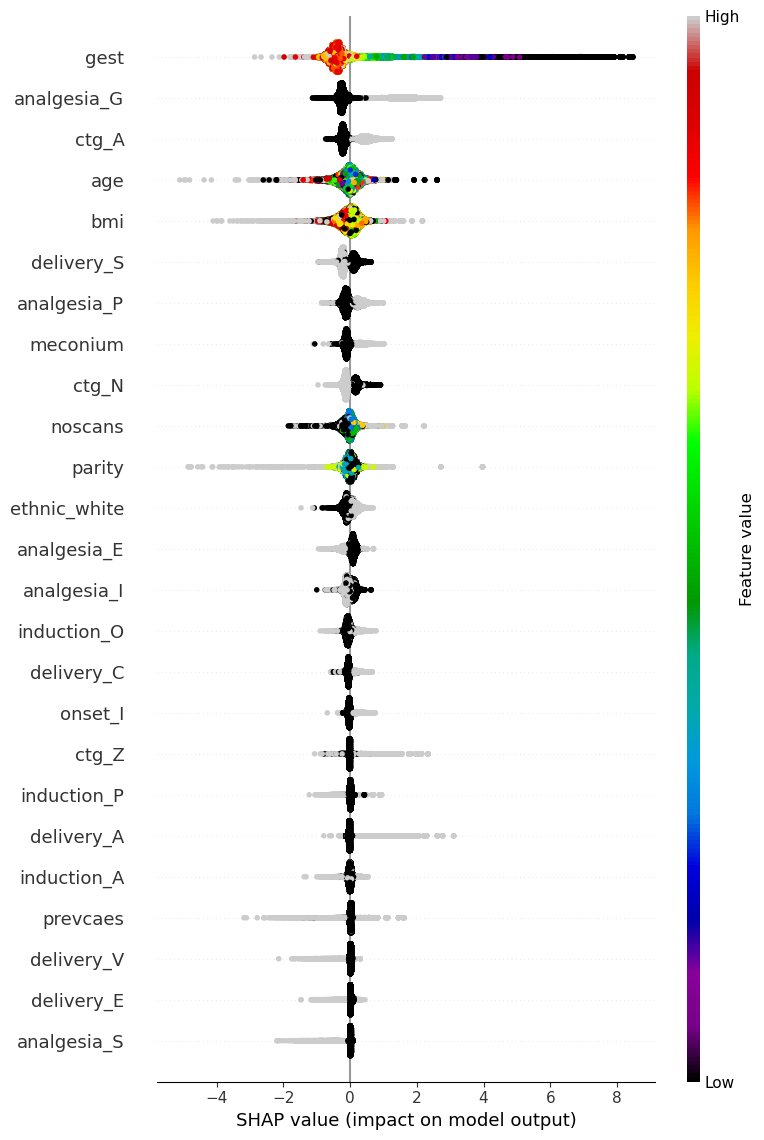

In [12]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_sample,
                  feature_names=list(X_sample),
                  max_display=25,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

plt.savefig(f'./output/shap_beeswarm_threshold_{threshold}.jpg', dpi=300)
plt.show()

In [13]:
df = pd.DataFrame(index=list(X))
df['feature_index'] = np.arange(len(list(X)))
df['mean_shap'] = np.mean(shap_values, axis=0)
df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df.sort_values('mean_abs_shap', ascending=False, inplace=True)

top_shap = list(df.index)
df.head(10)

,feature_index,mean_shap,mean_abs_shap
gest,7,0.274971,0.890185
analgesia_G,12,0.135307,0.502503
ctg_A,22,0.018040,0.294427
age,6,-0.062139,0.262271
bmi,5,-0.070301,0.244786
delivery_S,32,-0.069501,0.183911
analgesia_P,10,-0.003098,0.174385
meconium,4,-0.018281,0.161212
ctg_N,23,0.008240,0.160724
noscans,2,-0.046567,0.155268


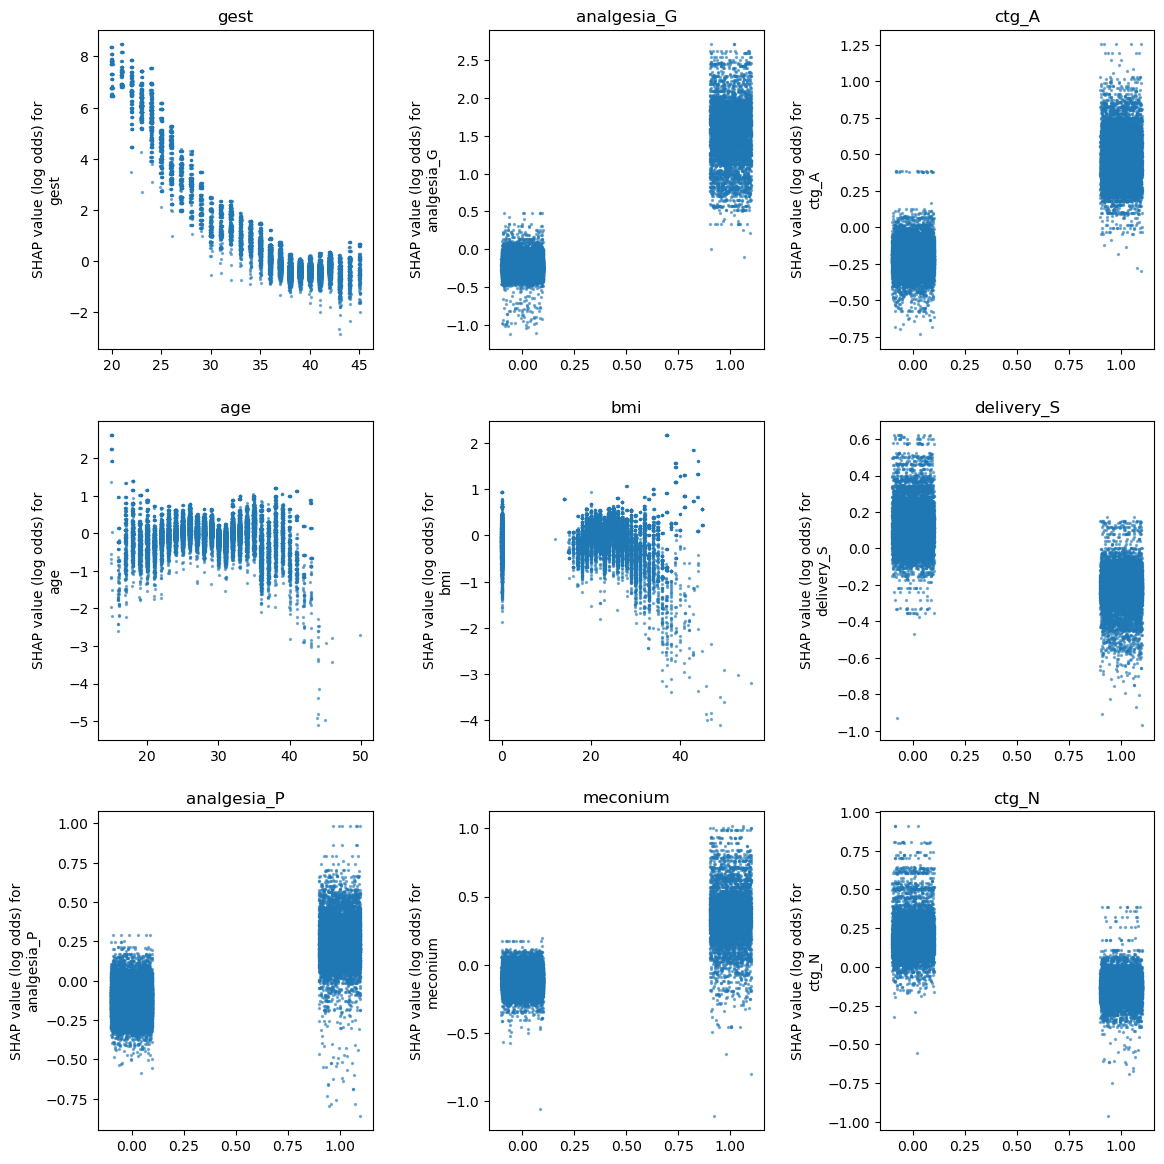

In [14]:
feat_to_show = top_shap[0:9]

fig = plt.figure(figsize=(12,12))
for n, feat in enumerate(feat_to_show):
    feat_index = int(df.loc[feat]['feature_index']) 
    ax = fig.add_subplot(3,3,n+1)

    shap_data = shap_values_extended[:].values[:,feat_index]
    feature_data = shap_values_extended[:].data[:,feat_index]

    jitter = -0.1 + (np.random.rand(len(feature_data))*0.2)

    ax.scatter(feature_data + jitter, shap_data, alpha=0.5, s=2)
  
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
plt.savefig(f'./output/shap_scatter_threshold_{threshold}.jpg', dpi=300)

plt.show()


## Feature selection

In [15]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
roc_auc_by_feature_number_kfold = []
chosen_features = []
best_auc = 0

# Initialise chosen features list and run tracker
available_features = list(X)
number_of_features = len(available_features)

# Loop through number of features
for i in range (20):
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''
    
    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        
        # Set up a list to hold AUC results for this feature for each kfold
        feature_roc_auc_kfold = []
        
        # Loop through the k-fold splits
        counter = 0
        for train_index, test_index in skf.split(X, y):
            counter += 1
    
            # Get X and Y train/test
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]            
            
            # Restrict features
            X_train = X_train[features_to_use]
            X_test = X_test[features_to_use]

            # Define model
            model = XGBClassifier(random_state=42)

            # Fit model
            model.fit(X_train, y_train)
            
            # Get predicted probabilities
            y_probs = model.predict_proba(X_test)[:,1]
            y_class = model.predict(X_test)
            
            fpr, tpr, thresholds = roc_curve(y_test, y_probs)
            # Use scikit-learn's method for calulcating auc
            roc_auc = auc(fpr, tpr)

            feature_roc_auc_kfold.append(roc_auc)

            # Remove model
            del model
        
        # Get average result from all k-fold splits``
        feature_auc_mean = np.mean(feature_roc_auc_kfold)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc_mean > best_result:
            best_result = feature_auc_mean
            best_result_kfold = feature_roc_auc_kfold
            best_feature = feature
            
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    roc_auc_by_feature_number_kfold.append(best_result_kfold)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)
            
    print (f'Feature {i+1:2.0f}: {best_feature}, AUC: {best_result:0.3f}')

Feature  1: gest, AUC: 0.684
Feature  2: analgesia_G, AUC: 0.776
Feature  3: age, AUC: 0.830
Feature  4: bmi, AUC: 0.897
Feature  5: noscans, AUC: 0.917
Feature  6: ctg_A, AUC: 0.927
Feature  7: analgesia_P, AUC: 0.934
Feature  8: onset_I, AUC: 0.940
Feature  9: parity, AUC: 0.946
Feature 10: analgesia_I, AUC: 0.950
Feature 11: induction_A, AUC: 0.954
Feature 12: ethnic_white, AUC: 0.959
Feature 13: ctg_N, AUC: 0.960
Feature 14: meconium, AUC: 0.961
Feature 15: delivery_S, AUC: 0.964
Feature 16: analgesia_E, AUC: 0.965
Feature 17: induction_O, AUC: 0.968
Feature 18: induction_P, AUC: 0.970
Feature 19: delivery_C, AUC: 0.970
Feature 20: delivery_O, AUC: 0.971


In [16]:
s = pd.Series(chosen_features)
s.to_csv('./output/feature_selection_threshold_{threshold}.csv', header=False)